Theory based on: 

In [1]:
import pandas as pd
import numpy as np
import os
import cv2 as cv
from scipy import ndimage, misc
from matplotlib import pyplot as plt
import imageio
import glob
import time
from tqdm import tqdm
from sklearn.datasets import load_boston, load_diabetes, load_digits, load_breast_cancer
from skimage.morphology import remove_small_objects
from sklearn.model_selection import train_test_split
%matplotlib inline

In [183]:
csvPath = 'CheXpert-v1.0-small-filtered/CheXpert-v1.0-small-filtered/filtered_train.csv'

dataFile = pd.read_csv(csvPath) 
# Preview the first 5 lines of the loaded data 
dataFile.head()

high = len(dataFile.index)
randInd = np.random.randint(high,size=10)
print(randInd)


df_no_lateral = dataFile[dataFile['Frontal/Lateral'] == 'Frontal']
print("high", high, "noLat high",len(df_no_lateral.index))

df_elements = df_no_lateral.sample(n=4)
print(df_elements, '\n')
rand_paths = df_elements[["Path","No Finding","Pleural Effusion","Frontal/Lateral"]]


paths = []
pleural = []
for i in range(4):
    paths.append(rand_paths.iloc[i][0])
    if rand_paths.iloc[i][2] == 1.0:
        pleural.append(1)
    else:
        pleural.append(0)
print(paths)
print(pleural)

[103312  77334  94552  83596  70683  22875  30107  65273  96075  34087]
high 108568 noLat high 93873
                                                     Path   Sex  Age  \
106319  CheXpert-v1.0-small/train/patient60057/study2/...  Male   23   
57886   CheXpert-v1.0-small/train/patient28946/study2/...  Male   23   
94990   CheXpert-v1.0-small/train/patient46528/study2/...  Male   67   
8595    CheXpert-v1.0-small/train/patient04572/study8/...  Male   83   

       Frontal/Lateral AP/PA  No Finding  Pleural Effusion  
106319         Frontal    AP         1.0               0.0  
57886          Frontal    AP         NaN               1.0  
94990          Frontal    AP         NaN               1.0  
8595           Frontal    AP         NaN               1.0   

['CheXpert-v1.0-small/train/patient60057/study2/view1_frontal.jpg', 'CheXpert-v1.0-small/train/patient28946/study2/view1_frontal.jpg', 'CheXpert-v1.0-small/train/patient46528/study2/view1_frontal.jpg', 'CheXpert-v1.0-small/train/pa

In [5]:
def neighbor_color(image):
    '''
    input:image, NxD np array
    output: image, NxD np array
    use: any black pixels connected to the edge of the image replaced with white pixels
    '''
    N, D = image.shape
    
    stack = []
    for i in range(N):
        stack.append((i,0))
        stack.append((i,D-1))
    for j in range(D):
        stack.append((0,j))
        stack.append((N-1,j))
    
    while(stack):
        (i,j) = stack.pop()
        #print("I,J",i,j)
        if image[i,j] == 0:
            image[i,j] = 255
            if i>0:
                stack.append((i-1,j))
            if i<(N-1):
                stack.append((i+1,j))
            if j>0:
                stack.append((i,j-1))
            if j<(D-1):
                stack.append((i,j+1))
        
    return image

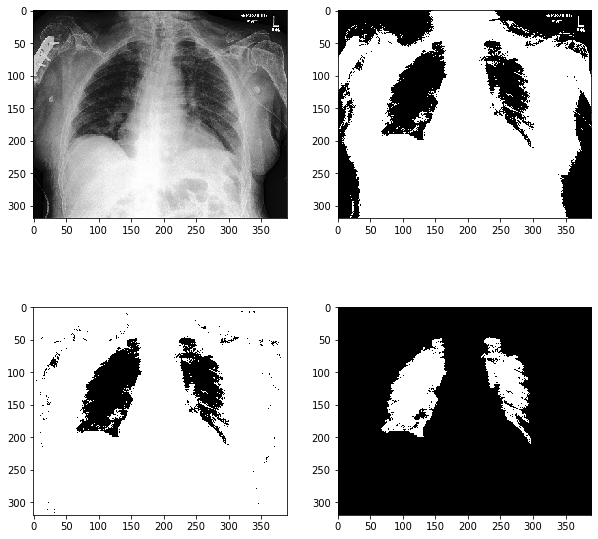

In [116]:
path2 = 'CheXpert-v1.0-small-filtered/CheXpert-v1.0-small-filtered/train/patient50598/study1/view1_frontal.jpg'
path = 'CheXpert-v1.0-small-filtered/CheXpert-v1.0-small-filtered/train/patient00001/study1/view1_frontal.jpg'


image2 = plt.imread(path2)
N, D = image2.shape
fig = plt.figure(figsize=(10,10))

ret,th1 = cv.threshold(image2,75,255,cv.THRESH_BINARY)
th2 = np.copy(th1)
th2 = neighbor_color(th2)
th2 = th2 > 0
th3 = remove_small_objects(np.invert(th2),min_size=2000)
images = [image2, th1, th2, th3]
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')

CheXpert-v1.0-small/train/patient60057/study2/view1_frontal.jpg
False
CheXpert-v1.0-small/train/patient28946/study2/view1_frontal.jpg
False
CheXpert-v1.0-small/train/patient46528/study2/view1_frontal.jpg
False
CheXpert-v1.0-small/train/patient04572/study8/view1_frontal.jpg
False


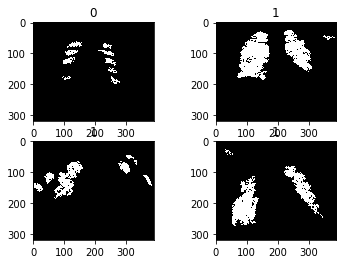

In [211]:
images = []
for path in paths:
    print(path)
    path = 'CheXpert-v1.0-small-filtered/CheXpert-v1.0-small-filtered' + path[19:]
    image = plt.imread(path)
    ret,th1 = cv.threshold(image,82,255,cv.THRESH_BINARY)
    th2 = np.copy(th1)
    th2 = neighbor_color(th2)
    th2 = th2 > 0
    th3 = remove_small_objects(np.invert(th2),min_size=200)
    print(th3[0,0])
    images.append(th3)
    
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(pleural[i])
    

1788
0.9966442953020134
10156
0.6326309570697125
5536
0.2846820809248555
8001
0.6354205724284464


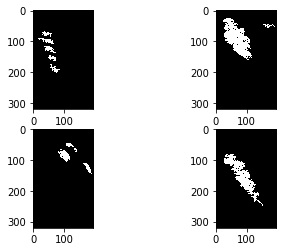

In [213]:
rightLung = []
leftLung = []
leftLungPixel = 0;
for xray in images:
    N,D = xray.shape
    rightHalf = int(D/2)
    rightLung.append( xray[:,:rightHalf])
    print(np.sum(xray[:,:rightHalf]))
    leftLung.append( xray[:,-rightHalf:])
    leftLungPixel = np.sum(xray[:,-rightHalf:])
    rightLungPixel = np.sum(xray[:,:rightHalf])
    print(np.sum(xray[:,-rightHalf:]) / np.sum(xray[:,:rightHalf]))
    
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(leftLung[i],'gray')


### Data Generation ###

In [100]:
csvPath = 'CheXpert-v1.0-small-filtered/CheXpert-v1.0-small-filtered/filtered_train.csv'

dataFile = pd.read_csv(csvPath) 
# Preview the first 5 lines of the loaded data 
dataFile.fillna(0, inplace=True)
dataFile.head()


#remove lateral views from database
df_no_lateral = dataFile[dataFile['Frontal/Lateral'] == 'Frontal']

#separate into pleural and no finding
df_pleural = df_no_lateral[df_no_lateral['Pleural Effusion'] == 1.0]
df_no_find = df_no_lateral[df_no_lateral['Pleural Effusion'] != 1.0]

#create a balanced number of pleural effusions
df_equal_pleural = df_pleural.sample(n=len(df_no_find.index))

frames = [df_equal_pleural, df_no_find]
df = pd.concat(frames)

df = df.sample(frac=1) #shuffle data

#split our data into test and training sets
train, test = train_test_split(df, test_size=0.2)

#extract our input path and the labels
xtrain_df = train['Path']
ytrain_df = train['Pleural Effusion']
xtest_df = test['Path']
ytest_df = test['Pleural Effusion']

#convert from Pandas Dataframe to list
xtrain = xtrain_df.values
ytrain = ytrain_df.values
xtest = xtest_df.values
ytest = ytest_df.values

### Preprocess Image / Extract Features ###

In [151]:
def preprocess(x):
    leftLungPixel = []
    rightLungPixel = []
    totalPixel = []
    leftToRight = []
    rightToTot = []
    for path in tqdm(x):
        #print(path)
        path = 'CheXpert-v1.0-small-filtered/CheXpert-v1.0-small-filtered' + path[19:]
        image = plt.imread(path)
        ret,th1 = cv.threshold(image,75,255,cv.THRESH_BINARY)
        th2 = np.copy(th1)
        th2 = neighbor_color(th2)
        th2 = th2 > 0
        th3 = remove_small_objects(np.invert(th2),min_size=200)
        #print(th3[0,0])
            
        N,D = image.shape
        rightHalf = int(D/2)
        
        leftPixel = np.sum(th3[:,-rightHalf:])
        rightPixel = np.sum(th3[:,:rightHalf])
        
        leftLungPixel.append(leftPixel)
        rightLungPixel.append(rightPixel)
        totalPixel.append(N*D)
        
        rightToTot.append(rightPixel/(N*D))
        
        if rightPixel == 0:
            rightPixel += 1
        leftToRight.append(leftPixel/rightPixel)
        
    return leftLungPixel, rightLungPixel, totalPixel, leftToRight, rightToTot
        
x = xtrain
y = ytrain
l,r,tot, feat1, feat2 = preprocess(x)
X = np.column_stack((feat1, feat2))
X_alt = np.reshape(feat1,(-1,1))

xtest1 = xtest
l1,r1,tot1,feat1_1,feat2_1=preprocess(xtest1)
X1 = np.column_stack((feat1_1, feat2_1))
X1_alt = np.reshape(feat1_1,(-1,1))
ytest1 = ytest


100%|██████████████████████████████████████████████████████████████████████████████| 6790/6790 [26:32<00:00,  5.20it/s]


In [152]:
feat3 = np.square(feat1) + np.square(feat2) + np.square(np.divide(l,(tot)))
X_alt_2 = np.column_stack((feat1, feat2, feat3))

feat3_1 = np.square(feat1_1) + np.square(feat2_1) + np.square(np.divide(l1,tot1))
X1_alt_2 = np.column_stack((feat1_1,feat2_1,feat3_1))


In [153]:
# from sklearn import neighbors

n_neighbors = range(3,1000,10)
plot_y2 = []
plot_y1 = []
plot_y3 = []
maxAcc = 0
for k in tqdm(n_neighbors):
    clf = neighbors.KNeighborsClassifier(k, weights='uniform')
    clf.fit(X,y)
    twoFeat = clf.score(X1,ytest1)
    plot_y2.append(twoFeat)
    if twoFeat > maxAcc:
        print("2 features at", twoFeat,"with ", k, "neighbors")
        maxAcc = twoFeat
    #print("2 feat and",k, "neighbors:",feat2)
    
    clf.fit(X_alt,y)
    oneFeat = clf.score(X1_alt,ytest1)
    plot_y1.append(oneFeat)
    if oneFeat > maxAcc:
        print("1 features at", oneFeat,"with ", k, "neighbors")
        maxAcc = oneFeat
    #print("1 feat and",k, "neighbors:",feat1)
    
    clf.fit(X_alt_2,y)
    thrFeat = clf.score(X1_alt_2,ytest1)
    plot_y3.append(thrFeat)
    if thrFeat > maxAcc:
        print("3 features at", thrFeat,"with ", k, "neighbors")
        maxAcc = thrFeat
    #print("3 feat and",k, "neighbors:",thrFeet)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

2 features at 0.6272459499263623 with  3 neighbors
3 features at 0.6294550810014727 with  3 neighbors


  1%|▊                                                                                 | 1/100 [00:00<01:31,  1.09it/s]

2 features at 0.6625920471281296 with  13 neighbors
3 features at 0.663181148748159 with  13 neighbors


  2%|█▋                                                                                | 2/100 [00:01<01:25,  1.15it/s]

2 features at 0.6736377025036819 with  23 neighbors


  3%|██▍                                                                               | 3/100 [00:02<01:20,  1.21it/s]

2 features at 0.6808541973490427 with  33 neighbors


  4%|███▎                                                                              | 4/100 [00:03<01:17,  1.24it/s]

2 features at 0.682179675994109 with  43 neighbors
3 features at 0.6840942562592047 with  43 neighbors


  5%|████                                                                              | 5/100 [00:03<01:16,  1.24it/s]

3 features at 0.6846833578792342 with  53 neighbors


  6%|████▉                                                                             | 6/100 [00:04<01:18,  1.20it/s]

3 features at 0.6852724594992636 with  63 neighbors


  9%|███████▍                                                                          | 9/100 [00:07<01:21,  1.11it/s]

2 features at 0.685419734904271 with  93 neighbors
3 features at 0.6855670103092784 with  93 neighbors


 11%|████████▉                                                                        | 11/100 [00:09<01:24,  1.06it/s]

2 features at 0.6873343151693667 with  113 neighbors


 12%|█████████▋                                                                       | 12/100 [00:10<01:26,  1.02it/s]

2 features at 0.6883652430044183 with  123 neighbors


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [04:36<00:00,  4.64s/it]


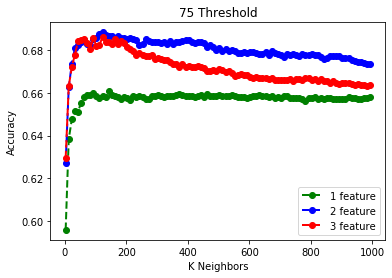

In [154]:
plt.plot(n_neighbors, plot_y1, 'g.--', linewidth=2, markersize=12,label='1 feature')
plt.plot(n_neighbors, plot_y2, 'b.--', linewidth=2, markersize=12,label= '2 feature')
plt.plot(n_neighbors, plot_y3, 'r.--', linewidth=2, markersize=12,label= '3 feature')

plt.xlabel('K Neighbors')
plt.ylabel('Accuracy')
plt.legend()
plt.title("75 Threshold")
plt.savefig('75_extended_neighbors.png')

In [158]:
clf = neighbors.KNeighborsClassifier(123, weights='uniform')
clf.fit(X,y)

predicted = clf.predict(X1)

labelStr = 'Path,Expected,Output\n'

f = open("results_knn.csv","w")

f.write(labelStr)

for i in range(len(xtest)):
    pathName = xtest[i]
    actual = ytest1[i]
    predict = predicted[i]
    str1 = pathName + "," + str(actual) + "," + str(predict) + '\n'
    f.write(str1)
    
f.close()
